# Purpose:
- I forgot to add whisking parameters before (amplitude, midpoint, num whisks)
- Copy the portion of adding whisker features from 221024_build_dataset.ipynb 
- Test if it works by comparing these values between video timeframe and 2p timeframe
- Add this to 230106_build_dataset_organized.ipynb
    - Then run it

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, shutil, tqdm, glob, h5py, mat73, imageio, napari
import seaborn as sns
from pathlib import Path
from scipy.io import loadmat
from tqdm import notebook
from suite2p.io.binary import BinaryFile

# h5_dir_1 = Path('H:/')
# h5_dir_2 = Path('F:/')
# b_dir = Path('D:/SoloData/')
# w_dir = Path('D:/WhiskerVideo/')
h5_dir = Path('E:/TPM/JK/h5')
b_dir = Path('E:/TPM/JK/SoloData/')
w_dir = Path('E:/TPM/JK/WhiskerVideo/')

mice =          [25,    27,   30,   36,     37,     38,     39,     41,     52,     53,     54,     56]
# refSessions =   [4,     3,    3,    1,      7,      2,      1,      3,      3,      3,      3,      3]
# expSessions =   [19,    10,   21,   17,     0,      0,      23,     0,      21,     0,      0,      0]
# zoom =          [2,     2,    2,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7]
image_rate_list = [30.8359, 30.8359, 30.8359, 30.8359, 
                    24.2892, 24.2892, 24.2892, 24.2892,
                    30.8359, 30.8359, 30.8359, 30.8359] # from .mat file (sbx)
image_size_list = [[512,796], [512,796], [512,796], [512,796], 
                    [650,796], [650,796], [650,796], [650,796], 
                    [512,796], [512,796], [512,796], [512,796]] # from .mat file (sbx)

planes = range(1,9)

# mice =          [25,    27,   30,   36,     39,     52]
# refSessions =   [4,     3,    3,    1,      1,      3]
# expSessions =   [19,    10,   21,   17,     23,     21]
# zoom =          [2,     2,    2,    1.7,    1.7,    1.7]
# freq =          [7.7,   7.7,  7.7,  7.7,    6.1,    7.7]

In [28]:
mouse = 25
plane = 1

session_num = 15
if session_num > 900:
    wb_snum = session_num // 10 + session_num % 900 # pre1 is 901 in calcium but 91 in behavior and whisker
else:
    wb_snum = session_num

# Load whisker
w_path = w_dir / f'JK{mouse:03d}S{wb_snum:02d}' / f'JK{mouse:03d}S{wb_snum:02d}_whisker.pkl'
whisker_df = pd.read_pickle(w_path)
# Load behavior
b_path = b_dir / f'JK{mouse:03d}' / f'JK{mouse:03d}S{wb_snum:02d}_behavior.pkl'
behavior_df = pd.read_pickle(b_path)
# Load frame times
tf_path = h5_dir / f'{mouse:03d}' / f'plane_{plane}' / f'{mouse:03d}_{session_num:03d}_plane_{plane}_frame_time.pkl'
frame_time_df = pd.read_pickle(tf_path)

whisker_df = pd.merge(whisker_df, behavior_df[['trialType']], on='trialNum', how='left')

In [38]:
# Merging whisker data to 2p time frames

# Initialization
# touch onset features
kappaH_onset = np.empty(len(frame_time_df))
kappaH_onset[:] = np.nan
kappaV_onset = np.empty(len(frame_time_df))
kappaV_onset[:] = np.nan
phi_onset = np.empty(len(frame_time_df))
phi_onset[:] = np.nan
theta_onset = np.empty(len(frame_time_df))
theta_onset[:] = np.nan
arc_length_onset = np.empty(len(frame_time_df))
arc_length_onset[:] = np.nan
touch_count = np.empty(len(frame_time_df))
touch_count[:] = np.nan
# during touch features
delta_kappaH = np.empty(len(frame_time_df))
delta_kappaH[:] = np.nan
delta_kappaV = np.empty(len(frame_time_df))
delta_kappaV[:] = np.nan
delta_phi = np.empty(len(frame_time_df))
delta_phi[:] = np.nan
delta_theta = np.empty(len(frame_time_df))
delta_theta[:] = np.nan
slide_distance = np.empty(len(frame_time_df))
slide_distance[:] = np.nan
touch_duration = np.empty(len(frame_time_df))
touch_duration[:] = np.nan
# pole frame
pole_up_frame = np.zeros(len(frame_time_df))
pole_moving_frame = np.zeros(len(frame_time_df))
# whisking features
theta = np.empty(len(frame_time_df))
theta[:] = np.nan
midpoint = np.empty(len(frame_time_df))
midpoint[:] = np.nan
amplitude = np.empty(len(frame_time_df))
amplitude[:] = np.nan
num_whisks = np.empty(len(frame_time_df))
num_whisks[:] = np.nan

trial_nums = frame_time_df.trialNum.unique()
whisker_empty_trial_nums = []
for trial_num in trial_nums:
    # 2p frame index and time
    trial_2p_index = np.where(frame_time_df.trialNum==trial_num)[0]
    trial_2p_time_pre = frame_time_df.frame_end_time.values[trial_2p_index] # end-to-end frame allocation
    med_frame_time_diff = np.median(np.diff(trial_2p_time_pre))
    trial_2p_time = np.array([trial_2p_time_pre[0]-med_frame_time_diff]+list(trial_2p_time_pre[:-1]))
    trial_2p_time_for_whisking = np.array([trial_2p_time_pre[0]-med_frame_time_diff]+list(trial_2p_time_pre))

    # First frame can be quite long, but there is no way that touch happened on the first frame
    # whisker touch time
    trial_whisker_series = whisker_df[whisker_df.index==trial_num]

    if len(trial_whisker_series) == 0: # No whisker processing (or error in the video, etc.)
        whisker_empty_trial_nums.append(trial_num)
    else:
        trial_whisker_time = trial_whisker_series.whisker_time.values[0]

        trial_kappaH = trial_whisker_series.kappaH.values[0]
        trial_kappaV = trial_whisker_series.kappaV.values[0]
        trial_phi = trial_whisker_series.phi.values[0]
        trial_theta = trial_whisker_series.theta.values[0]
        trial_arc_length = trial_whisker_series.arcLength.values[0]

        if trial_whisker_series.trialType.values[0] != 'oo':  # 'oo' denotes out of reach pole up trials. No touch happened, and no pole up could be detected from the video reliably.

            trial_protraction_touch_chunks = trial_whisker_series.protractionTFchunksByWhisking.values[0] # when touch frame chunks by whisking were used
            # trial_protraction_touch_chunks = trial_whisker_series.protractionTFchunks.values[0] # in case when touch frame chunks were used
            if len(trial_protraction_touch_chunks)>0:
                assert len(trial_protraction_touch_chunks) == len(trial_whisker_series.protractionSlideByWhisking.values[0])
                # touch_onset_times = [trial_whisker_time[touch_chunks[0].astype(int)-1] for touch_chunks in trial_protraction_touch_chunks]
                for touch_ind, touch_chunk_whisker_index in enumerate(trial_protraction_touch_chunks):
                    if np.ndim(touch_chunk_whisker_index) == 0:
                        touch_chunk_whisker_index = np.asarray([touch_chunk_whisker_index])
                    touch_chunk_whisker_index = touch_chunk_whisker_index.astype(int)-1 # correcting 1-based MATLAB index to 0-based python index
                    touch_onset_time = trial_whisker_time[touch_chunk_whisker_index[0]]
                    touch_onset_2p_index = np.where(trial_2p_time>touch_onset_time)[0][0]

                    # Assign touch onset features
                    kappaH_first = trial_kappaH[touch_chunk_whisker_index[0]]
                    kappaV_first = trial_kappaV[touch_chunk_whisker_index[0]]
                    phi_first = trial_phi[touch_chunk_whisker_index[0]]
                    theta_first = trial_theta[touch_chunk_whisker_index[0]]

                    if np.isnan(kappaH_onset[trial_2p_index[touch_onset_2p_index]]):
                        kappaH_onset[trial_2p_index[touch_onset_2p_index]] = kappaH_first 
                    else:
                        kappaH_onset[trial_2p_index[touch_onset_2p_index]] += kappaH_first 
                    if np.isnan(kappaV_onset[trial_2p_index[touch_onset_2p_index]]):
                        kappaV_onset[trial_2p_index[touch_onset_2p_index]] = kappaV_first
                    else:
                        kappaV_onset[trial_2p_index[touch_onset_2p_index]] += kappaV_first
                    if np.isnan(phi_onset[trial_2p_index[touch_onset_2p_index]]):
                        phi_onset[trial_2p_index[touch_onset_2p_index]] = phi_first
                    else:
                        phi_onset[trial_2p_index[touch_onset_2p_index]] += phi_first
                    if np.isnan(theta_onset[trial_2p_index[touch_onset_2p_index]]):
                        theta_onset[trial_2p_index[touch_onset_2p_index]] = theta_first
                    else:
                        theta_onset[trial_2p_index[touch_onset_2p_index]] += theta_first
                    
                    if np.isnan(arc_length_onset[trial_2p_index[touch_onset_2p_index]]):
                        arc_length_onset[trial_2p_index[touch_onset_2p_index]] = trial_arc_length[touch_chunk_whisker_index[0]]
                    else:
                        arc_length_onset[trial_2p_index[touch_onset_2p_index]] += trial_arc_length[touch_chunk_whisker_index[0]]
                    if np.isnan(touch_count[trial_2p_index[touch_onset_2p_index]]):
                        touch_count[trial_2p_index[touch_onset_2p_index]] = 1
                    else:
                        touch_count[trial_2p_index[touch_onset_2p_index]] += 1

                    # Assign during touch features
                    touch_offset_time = trial_whisker_time[touch_chunk_whisker_index[-1]]
                    touch_offset_2p_index = np.where(trial_2p_time>touch_offset_time)[0][0]
                    slide_distance_trial = trial_whisker_series.protractionSlideByWhisking.values[0][touch_ind]
                    if np.ndim(slide_distance_trial) == 0:
                        slide_distance_trial = np.asarray([slide_distance_trial])
                    for touch_2p_index in range(touch_onset_2p_index,touch_offset_2p_index+1):
                        # kappaH, kappaV, phi, theta, requires calculating max values within the frame, compared to the first value
                        current_2p_frame_end_time = trial_2p_time[touch_2p_index]
                        if trial_whisker_time[touch_chunk_whisker_index[-1]] > current_2p_frame_end_time: # when the current touch chunk ends later than the current 2p frame end time
                            last_whisker_index_within_frame = np.where(trial_whisker_time[touch_chunk_whisker_index] > current_2p_frame_end_time)[0][0] # excluding this index
                        else:
                            last_whisker_index_within_frame = len(touch_chunk_whisker_index) # excluding this index
                        
                        kappaH_within_frame = trial_kappaH[touch_chunk_whisker_index[:last_whisker_index_within_frame]]
                        if np.isnan(delta_kappaH[trial_2p_index[touch_2p_index]]):
                            delta_kappaH[trial_2p_index[touch_2p_index]] = np.amin(kappaH_within_frame - kappaH_first) # For protraction touch, only negative values are allowed
                        else:
                            delta_kappaH[trial_2p_index[touch_2p_index]] += np.amin(kappaH_within_frame - kappaH_first)

                        kappaV_within_frame = trial_kappaV[touch_chunk_whisker_index[:last_whisker_index_within_frame]]
                        if np.isnan(delta_kappaV[trial_2p_index[touch_2p_index]]):
                            delta_kappaV[trial_2p_index[touch_2p_index]] = np.amax(np.abs(kappaV_within_frame - kappaV_first)) * np.sign(kappaV_within_frame[np.argmax(np.abs(kappaV_within_frame - kappaV_first))] - kappaV_first)
                        else:
                            delta_kappaV[trial_2p_index[touch_2p_index]] += np.amax(np.abs(kappaV_within_frame - kappaV_first)) * np.sign(kappaV_within_frame[np.argmax(np.abs(kappaV_within_frame - kappaV_first))] - kappaV_first)

                        phi_within_frame = trial_phi[touch_chunk_whisker_index[:last_whisker_index_within_frame]]
                        if np.isnan(delta_phi[trial_2p_index[touch_2p_index]]):
                            delta_phi[trial_2p_index[touch_2p_index]] = np.amax(np.abs(phi_within_frame - phi_first)) * np.sign(phi_within_frame[np.argmax(np.abs(phi_within_frame - phi_first))] - phi_first)
                        else:
                            delta_phi[trial_2p_index[touch_2p_index]] += np.amax(np.abs(phi_within_frame - phi_first)) * np.sign(phi_within_frame[np.argmax(np.abs(phi_within_frame - phi_first))] - phi_first)
                        
                        theta_within_frame = trial_theta[touch_chunk_whisker_index[:last_whisker_index_within_frame]]
                        if np.isnan(delta_theta[trial_2p_index[touch_2p_index]]):
                            delta_theta[trial_2p_index[touch_2p_index]] = np.amax(theta_within_frame - theta_first) # For protraction touch, only positive values are allowed
                        else:
                            delta_theta[trial_2p_index[touch_2p_index]] += np.amax(theta_within_frame - theta_first)

                        # Slide distance already calculated per whisker time frame, so only requires calculating max values within the frame
                        slide_distance_within_frame = slide_distance_trial[:last_whisker_index_within_frame]
                        if np.isnan(slide_distance[trial_2p_index[touch_2p_index]]):
                            slide_distance[trial_2p_index[touch_2p_index]] = np.amax(slide_distance_within_frame)
                        else:
                            slide_distance[trial_2p_index[touch_2p_index]] += np.amax(slide_distance_within_frame)

                        # Touch duration
                        if np.isnan(touch_duration[trial_2p_index[touch_2p_index]]):
                            touch_duration[trial_2p_index[touch_2p_index]] = trial_whisker_time[touch_chunk_whisker_index[last_whisker_index_within_frame-1]] - touch_onset_time
                        else:
                            touch_duration[trial_2p_index[touch_2p_index]] += trial_whisker_time[touch_chunk_whisker_index[last_whisker_index_within_frame-1]] - touch_onset_time
            
            # Adding pole-up frames and pole-moving frames
            pole_moving_time = trial_whisker_time[trial_whisker_series.poleMovingFrames.values[0].astype(int)-1]
            pole_up_time = trial_whisker_time[trial_whisker_series.poleUpFrames.values[0].astype(int)-1]
            pole_up_2p_frame_first_ind = np.where(trial_2p_time > pole_up_time[0])[0][0]

            if len(np.where(trial_2p_time > pole_up_time[-1])[0]) > 0:
                pole_up_2p_frame_last_ind = np.where(trial_2p_time > pole_up_time[-1])[0][0]
            else:
                pole_up_2p_frame_last_ind = len(trial_2p_time)-1
            pole_up_frame[trial_2p_index[pole_up_2p_frame_first_ind:pole_up_2p_frame_last_ind+1]] = 1

            pole_moving_2p_frame_first_ind = np.where(trial_2p_time > pole_moving_time[0])[0][0]
            pole_moving_frame[trial_2p_index[pole_moving_2p_frame_first_ind:pole_up_2p_frame_first_ind]] = 1

            if pole_moving_time[-1] > pole_up_time[-1]: # only when pole moving happened also after pole up
                if len(np.where(trial_2p_time > pole_moving_time[-1])[0]) > 0:
                    pole_moving_2p_frame_last_ind = np.where(trial_2p_time > pole_moving_time[-1])[0][0]
                    pole_moving_frame[trial_2p_index[pole_up_2p_frame_last_ind+1:pole_moving_2p_frame_last_ind+1]] = 1
            
        # Adding whisking features (theta, midpoint, amplitude, num_whisks)
        # average theta, midpoint, amplitude
        # sume num_whisks
        assert len(trial_2p_index) == len(trial_2p_time_for_whisking) - 1
        for ti in range(len(trial_2p_time_for_whisking)-1):
            trange = [trial_2p_time_for_whisking[ti], trial_2p_time_for_whisking[ti+1]]
            whisker_time_within_range = trial_whisker_time[(trial_whisker_time>=trange[0]) & (trial_whisker_time<trange[1])]
            if len(whisker_time_within_range) == 0:
                continue
            wtrange = np.where((trial_whisker_time>=trange[0]) & (trial_whisker_time<trange[1]))[0]

            whisking_start_frames = trial_whisker_series.whiskingStartFrames.values[0]-1 # 0-based index

            theta[trial_2p_index[ti]] = np.mean(trial_whisker_series.theta.values[0][wtrange])
            midpoint[trial_2p_index[ti]] = np.mean(trial_whisker_series.midpoint.values[0][wtrange])
            amplitude[trial_2p_index[ti]] = np.mean(trial_whisker_series.amplitude.values[0][wtrange])
            num_whisks[trial_2p_index[ti]] = len(np.where((whisking_start_frames >= wtrange[0]) &
                                                          (whisking_start_frames <= wtrange[-1]))[0])


# Adding whisker features to frame time DataFrame
frame_time_df['kappaH_onset'] = kappaH_onset
frame_time_df['kappaV_onset'] = kappaV_onset
frame_time_df['phi_onset'] = phi_onset
frame_time_df['theta_onset'] = theta_onset
frame_time_df['arc_length_onset'] = arc_length_onset
frame_time_df['touch_count'] = touch_count
frame_time_df['delta_kappaH'] = delta_kappaH
frame_time_df['delta_kappaV'] = delta_kappaV
frame_time_df['delta_phi'] = delta_phi
frame_time_df['delta_theta'] = delta_theta
frame_time_df['slide_distance'] = slide_distance
frame_time_df['touch_duration'] = touch_duration

frame_time_df['pole_up_frame'] = pole_up_frame
frame_time_df['pole_moving_frame'] = pole_moving_frame

frame_time_df['theta'] = theta
frame_time_df['midpoint'] = midpoint
frame_time_df['amplitude'] = amplitude
frame_time_df['num_whisks'] = num_whisks

# Remove frames from trial_num that had error in whisker processing
frame_time_df = frame_time_df[~np.isin(frame_time_df.trialNum.values, np.asarray(whisker_empty_trial_nums))]

In [37]:
whisker_time_within_range

array([], dtype=float64)

In [32]:
trange

[46.40042379580294, 46.53014272730811]

In [19]:
whisker_df

,amplitude,arcLength,kappaH,kappaV,midpoint,phase,phi,poleAngle,poleDistance,poleMovingFrames,...,retractionTFchunks,retractionTFchunksByWhisking,retractionTouchDuration,retractionTouchDurationByWhisking,theta,whisker_time,whiskingStartFrames,mouse_name,session_name,trialType
trialNum,,,,,,,,,,,,,,,,,,,,,
2,"[7.4287802417482425, 3.8094739378507345, 3.433...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0720011909614487, 0.07149432979532429, 0.06...","[-0.08123635241860128, -0.0799072694825568, -0...","[-25.410131843532096, -25.392853350509693, -25...","[-1.5688384650205882, -1.54635302243285, -1.52...","[14.805890267118505, 14.833741563128843, 14.89...",45,100000,"[379.0, 380.0, 381.0, 382.0, 383.0, 384.0, 385...",...,[],[],"[0, 0]","[0, 0]","[-25.38739580652244, -25.43434264355532, -25.0...","[0.0, 0.0032129546330805807, 0.006425909266161...","[1.0, 344.0, 380.0, 408.0, 434.0, 445.0, 471.0...",JK036,S03,rn
3,"[1.044746304224738, 0.43075483308359597, 0.751...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.07367413813533964, 0.07277579634011198, 0.0...","[-0.07605408937632653, -0.07517091260804337, -...","[-19.83385405022655, -19.483067088592147, -19....","[-1.6004762503934393, -3.051775063487028, -3.0...","[17.221776881301675, 17.51549915551591, 16.358...",45,100000,"[363.0, 364.0, 365.0, 366.0, 367.0, 368.0, 369...",...,[],[],"[0, 0]","[0, 0]","[-20.17430262550558, -20.912654069100842, -21....","[0.0, 0.0032129546330805807, 0.006425909266161...","[5.0, 26.0, 48.0, 59.0, 80.0, 104.0, 131.0, 16...",JK036,S03,rn
4,"[0.7223312035600715, 0.7898901547596473, 1.029...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.07026644628508807, 0.0701979230428759, 0.07...","[-0.0799599373348605, -0.08152073917224512, -0...","[-17.00082216504471, -17.262753000542745, -17....","[1.6186315694415674, 1.4925217534980664, 1.487...","[18.87927590502002, 18.714769181648357, 19.491...",135,100000,"[355.0, 356.0, 357.0, 358.0, 359.0, 360.0, 361...",...,[],[],"[0, 0]","[0, 0]","[-16.656137218045483, -16.375904583364456, -17...","[0.0, 0.0032129546330805807, 0.006425909266161...","[1.0, 14.0, 56.0, 94.0, 142.0, 159.0, 180.0, 1...",JK036,S03,ln
5,"[0.17968423232358108, 0.4397132592065189, 0.53...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.06858040625609796, 0.06663722607328497, 0.0...","[-0.08820898528359077, -0.08644904947575463, -...","[-30.00290632311821, -30.0211559022538, -30.03...","[-2.1848851749290024, 2.4266384681615927, 2.91...","[21.358462907209134, 21.23605594413188, 22.104...",45,100000,"[361.0, 362.0, 363.0, 364.0, 365.0, 366.0, 367...",...,[],[],"[0, 0]","[0, 0]","[-30.13958799067319, -30.49820797343682, -30.8...","[0.0, 0.0032129546330805807, 0.006425909266161...","[49.0, 501.0, 542.0, 563.0, 580.0, 599.0, 650....",JK036,S03,rn
6,"[0.4662122967957694, 0.20774732714134048, 0.31...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0683500426093284, 0.06810574595973164, 0.06...","[-0.08536836099665226, -0.08474766825415779, -...","[-26.95787978027107, -26.96039795440136, -26.9...","[-1.5859196779735607, 2.574047658014806, 3.133...","[25.620901265052044, 25.38626333715332, 25.387...",45,100000,"[360.0, 361.0, 362.0, 363.0, 364.0, 365.0, 366...",...,[],[],"[0, 0]","[0, 0]","[-26.935336900549288, -27.06127724323571, -27....","[0.0, 0.0032129546330805807, 0.006425909266161...","[613.0, 647.0, 667.0, 676.0, 721.0, 761.0, 790...",JK036,S03,rn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,"[14.544887463737082, 19.59892604827893, 21.101...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.055351932225915786, 0.055611768580673356, 0...","[-0.06740834702556274, -0.07596518249520817, -...","[18.230278925418325, 16.384678685921855, 14.49...","[1.5828369306255712, 1.9450664253596646, 2.262...","[4.6249073703615355, 7.405184975659625, 10.012...",45,100000,"[360.0, 361.0, 362.0, 363.0, 364.0, 365.0, 366...",...,[],[],"[0, 0]","[0, 0]","[20.527101126492195,

In [23]:
temp_ftdf.theta.values

array([], dtype=float64)

In [26]:
frame_time_df.trialNum.unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 232, 233, 234, 235, 236,
       237, 238, 239, 240, 241, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 292,
       293, 294, 295, 296, 297, 298, 299, 300, 301, 312, 313, 314, 315,
       316, 317, 318, 319, 320, 321, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
       372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 

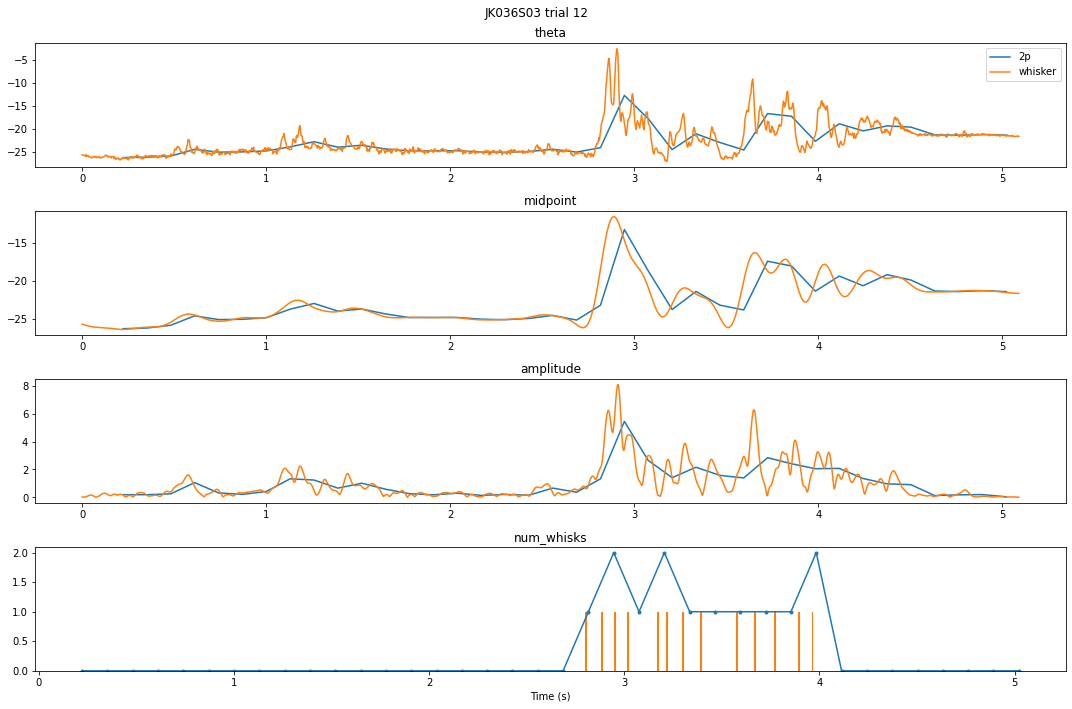

In [27]:
# compare theta, midpoint, amplitude and num_whisks visually
trial_num = frame_time_df.trialNum.unique()[0]
temp_wdf = whisker_df[whisker_df.index==trial_num]
temp_ftdf = frame_time_df[frame_time_df.trialNum==trial_num]
tpm_time = temp_ftdf.apply(lambda x: np.mean([x.frame_start_time, x.frame_end_time]), axis=1).values
fig, ax = plt.subplots(4,1,figsize=(15,10))
ax[0].plot(tpm_time, temp_ftdf.theta.values, label='2p')
ax[0].plot(temp_wdf.whisker_time.values[0], temp_wdf.theta.values[0], label='whisker')
ax[0].set_title('theta')
ax[0].legend()
ax[1].plot(tpm_time, temp_ftdf.midpoint.values, label='2p')
ax[1].plot(temp_wdf.whisker_time.values[0], temp_wdf.midpoint.values[0], label='whisker')
ax[1].set_title('midpoint')
ax[2].plot(tpm_time, temp_ftdf.amplitude.values, label='2p')
ax[2].plot(temp_wdf.whisker_time.values[0], temp_wdf.amplitude.values[0], label='whisker')
ax[2].set_title('amplitude')
ax[3].plot(tpm_time, temp_ftdf.num_whisks.values, '.-', label='2p')
ax[3].bar(temp_wdf.whisker_time.values[0][temp_wdf.whiskingStartFrames.values[0].astype(int)-1], 1, 
          width=0.01, color='C1', label='whisker')
ax[3].set_title('num_whisks')
ax[3].set_xlabel('Time (s)')
fig.suptitle(f'JK{mouse:03d}S{session_num:02d} trial {trial_num}')
fig.tight_layout()

In [7]:
temp_wdf.keys()

Index(['amplitude', 'arcLength', 'kappaH', 'kappaV', 'midpoint', 'phase',
       'phi', 'poleAngle', 'poleDistance', 'poleMovingFrames', 'polePosition',
       'poleUpFrames', 'protractionSlide', 'protractionSlideByWhisking',
       'protractionTFchunks', 'protractionTFchunksByWhisking',
       'protractionTouchDuration', 'protractionTouchDurationByWhisking',
       'retractionSlide', 'retractionSlideByWhisking', 'retractionTFchunks',
       'retractionTFchunksByWhisking', 'retractionTouchDuration',
       'retractionTouchDurationByWhisking', 'theta', 'whisker_time',
       'whiskingStartFrames', 'mouse_name', 'session_name'],
      dtype='object')

In [8]:
trial_num = 2
trial_2p_index = np.where(frame_time_df.trialNum==trial_num)[0]
trial_2p_time = frame_time_df.frame_end_time.values[trial_2p_index]
trial_2p_time_pre = frame_time_df.frame_end_time.values[trial_2p_index] # end-to-end frame allocation
med_frame_time_diff = np.median(np.diff(trial_2p_time_pre))
trial_2p_time = np.array([trial_2p_time_pre[0]-med_frame_time_diff]+list(trial_2p_time_pre[:-1]))
trial_2p_time_for_whisking = np.array([trial_2p_time_pre[0]-med_frame_time_diff]+list(trial_2p_time_pre))

trial_whisker_series = whisker_df[whisker_df.index==trial_num]
trial_whisker_time = trial_whisker_series.whisker_time.values[0]

ti = 3
trange = [trial_2p_time_for_whisking[ti], trial_2p_time_for_whisking[ti+1]]
whisker_time_within_range = trial_whisker_time[(trial_whisker_time>=trange[0]) & (trial_whisker_time<trange[1])]
wtrange = np.where((trial_whisker_time>=trange[0]) & (trial_whisker_time<trange[1]))[0]
theta[trial_2p_index[ti]] = np.mean(trial_whisker_series.theta.values[0][wtrange])
midpoint[trial_2p_index[ti]] = np.mean(trial_whisker_series.midpoint.values[0][wtrange])
amplitude[trial_2p_index[ti]] = np.mean(trial_whisker_series.amplitude.values[0][wtrange])
num_whisks[trial_2p_index[ti]] = len(np.where((trial_whisker_series.whiskingStartFrames.values[0] >= wtrange[0]) &
                                              (trial_whisker_series.whiskingStartFrames.values[0] <= wtrange[-1]))[0])



In [9]:
trial_whisker_series.whiskingStartFrames.values[0]

array([ 154.,  173.,  198.,  206.,  234.,  278.,  309.,  321.,  424.,
        438.,  469., 1189., 1231., 1267., 1308., 1337., 1364., 1380.,
       1393., 1400., 1436., 1468., 1473., 1491., 1524., 1557., 1570.,
       1600., 1626.])

In [10]:
wtrange

array([160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200], dtype=int64)

In [11]:
len(np.where((trial_whisker_series.whiskingStartFrames.values[0] >= wtrange[0]) &
                                              (trial_whisker_series.whiskingStartFrames.values[0] <= wtrange[-1]))[0])

2